In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms

import yaml
import random
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
timesteps = 50
dt = 1e-3
tau_syn = 5e-3
tau_mem = 20e-3

neuron_params = {
        "threshold": 1.0,
        "i_offset": 0.0,
        "reset": "reset_to_v_reset",
        "dt": dt,
        "tau_mem": tau_mem,
        "tau_syn": tau_syn,
    }
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [19]:
# dims = [1, 1, 1]
dims = [196, 100, 2]

gains = np.array([5, 5]) * 1e0
# gains = np.array([10, 16]) * 1e-0
np.random.seed(42)
use_loss = True

# input_spike_times = {
#     n: np.where(
#         np.random.poisson(lam=0.2, size=(timesteps - 1)).clip(0, 1).astype(int)
#     )[0].tolist()
#     for n in range(dims[0])
# }
input_spike_times = {
    k: np.random.choice(np.arange(timesteps-1), size=1) for k in range(dims[0])
}

# input_spike_times = {0 : [10], 1 : [20]}
# input_spike_times = {0: [0, 3, 5, 7, 10]}

print(input_spike_times)
input_spikes = np.zeros((timesteps, 1, dims[0]))
for n, times in input_spike_times.items() : 
    input_spikes[times, 0, n] = 1

input_spikes = torch.from_numpy(input_spikes).float().to(device)

{0: array([38]), 1: array([28]), 2: array([14]), 3: array([42]), 4: array([7]), 5: array([20]), 6: array([38]), 7: array([18]), 8: array([22]), 9: array([10]), 10: array([10]), 11: array([23]), 12: array([35]), 13: array([39]), 14: array([23]), 15: array([2]), 16: array([21]), 17: array([1]), 18: array([23]), 19: array([43]), 20: array([29]), 21: array([37]), 22: array([1]), 23: array([20]), 24: array([32]), 25: array([11]), 26: array([21]), 27: array([43]), 28: array([24]), 29: array([48]), 30: array([26]), 31: array([41]), 32: array([27]), 33: array([15]), 34: array([14]), 35: array([46]), 36: array([43]), 37: array([2]), 38: array([36]), 39: array([6]), 40: array([20]), 41: array([8]), 42: array([38]), 43: array([17]), 44: array([3]), 45: array([24]), 46: array([13]), 47: array([8]), 48: array([25]), 49: array([1]), 50: array([19]), 51: array([27]), 52: array([46]), 53: array([6]), 54: array([43]), 55: array([7]), 56: array([46]), 57: array([34]), 58: array([13]), 59: array([16]), 6

In [20]:
from eventprop.models import SNN

In [21]:
model_config = {
    "T": timesteps,
    "dt": dt,
    "tau_m": tau_mem,
    "tau_s": tau_syn,
    "mu": 1.,
    "resolve_silent": False,
    "device": device,
    "get_first_spikes": False,
    "model_type" : "eventprop",
    "reset_to_zero" : True
}


In [22]:
eventprop_model = SNN(dims, **model_config)
layers = eventprop_model.layers
for layer, gain in zip(layers, gains) : 
    n2, n1 = layer.weight.shape
    nu = 1. / np.sqrt(n1)
    layer.weight.data = torch.from_numpy(np.random.normal(nu, nu, size=(n1, n2))).T.float() * gain
    # layer.weight.data = torch.zeros((n2, n1)).float()
    # layer.weight.data[0, :] = 1
    # layer.weight.data[-1, :] = -1


    # layer.weight.data = torch.ones((n2, n1)).float() * gain
eventprop_model.to(device)

SNN(
  (layers): RecordingSequential(
    (0): SpikingLinear_ev(196, 100)
    (1): SpikingLinear_ev(100, 2)
  )
)

In [23]:
packs = []
input = input_spikes.to(device)	
for layer in layers : 
    pack, _ = layer.manual_forward(input)
    packs.append(pack)
    input = pack[-1]

In [24]:
(inputs, Vs, V_spikes, Is, all_out_spikes) = list(zip(*packs))

In [25]:
all_spike_times = {}
for layer_id, (out_spikes, dim) in enumerate(zip(all_out_spikes, dims[1:])) : 
    all_spike_times[layer_id] = {}
    
    spike_times = torch.where(out_spikes[:, 0])
    spike_times = {
        n : spike_times[0][spike_times[1] == n].cpu().data.numpy() for n in range(dim)
    }
    spike_times
    first_spike_times = {
        n : spike_times[n][0] if len(spike_times[n]) > 0 else -1 for n in range(dim)
    }
    first_spikes_only = torch.zeros_like(out_spikes)
    for n in range(dim) : 
        if first_spike_times[n] > 0 : 
            first_spikes_only[first_spike_times[n], 0, n] = 1
    all_spike_times[layer_id]["all"] = spike_times
    all_spike_times[layer_id]["first"] = first_spike_times

In [26]:
LOSS_ALPHA = 3e-3
LOSS_TAU_0 = 5e-4
LOSS_TAU_0_INV = 1. / LOSS_TAU_0
LOSS_TAU_1 = 6.4e-3
LOSS_DT = 1e-3
LOSS_DT_TAU_0_RATIO = LOSS_DT / LOSS_TAU_0
LOSS_DT_TAU_1_RATIO = LOSS_DT / LOSS_TAU_1
LOSS_ALPHA_TAU_1_RATIO = LOSS_ALPHA / LOSS_TAU_1

In [27]:
if False :
    labels = 0
    first_spike_errors = {
        n : 0 for n in range(dims[1])
    }
    t_l = first_spike_times[labels]
    sum0 = 0
    for n in range(dims[-1]) : 
        if first_spike_times[n] != -1 : 
            sum0 += np.exp(-(first_spike_times[n] ) * LOSS_DT_TAU_0_RATIO)
        
    label_error = LOSS_TAU_0_INV * (1 - np.exp(-t_l * LOSS_DT_TAU_0_RATIO) / sum0) + LOSS_ALPHA_TAU_1_RATIO * np.exp(t_l * LOSS_DT_TAU_1_RATIO)
    first_spike_errors[labels] += label_error
    for n in range(dims[-1]) : 
        if first_spike_times[n] != -1 and labels != n: 
            first_spike_errors[n] = -LOSS_TAU_0_INV * (1 / sum0) * np.exp(-(first_spike_times[n]) * LOSS_DT_TAU_0_RATIO) 
else : 
    label = 0
    first_spike_errors = {
        n : 1 if n == label else -1 for n in range(dims[-1])
    }

In [28]:
first_spike_grads = torch.cat(list({
    n : spikes * error for spikes, (n, error) in zip(first_spikes_only.split(1, dim=-1), first_spike_errors.items())
}.values()), -1)

In [29]:
bw_packs = []
grads = first_spike_grads
for layer, pack in zip(layers[::-1], packs[::-1]) :         
    bw_pack = layer.manual_backward(grads, pack)
    grads = bw_pack[0]
    bw_packs.append(bw_pack)


In [30]:
grad_inputs, grad_weights, lVs, lIs = list(zip(*bw_packs[::-1]))

In [31]:
all_spike_times['stim'] = {}
all_spike_times['stim']['all'] = input_spike_times
all_spike_times = dict(sorted(all_spike_times.items(), key=lambda x : x != 'stim'))

In [32]:
sources = ['stim'] + list(range(len(layers)))

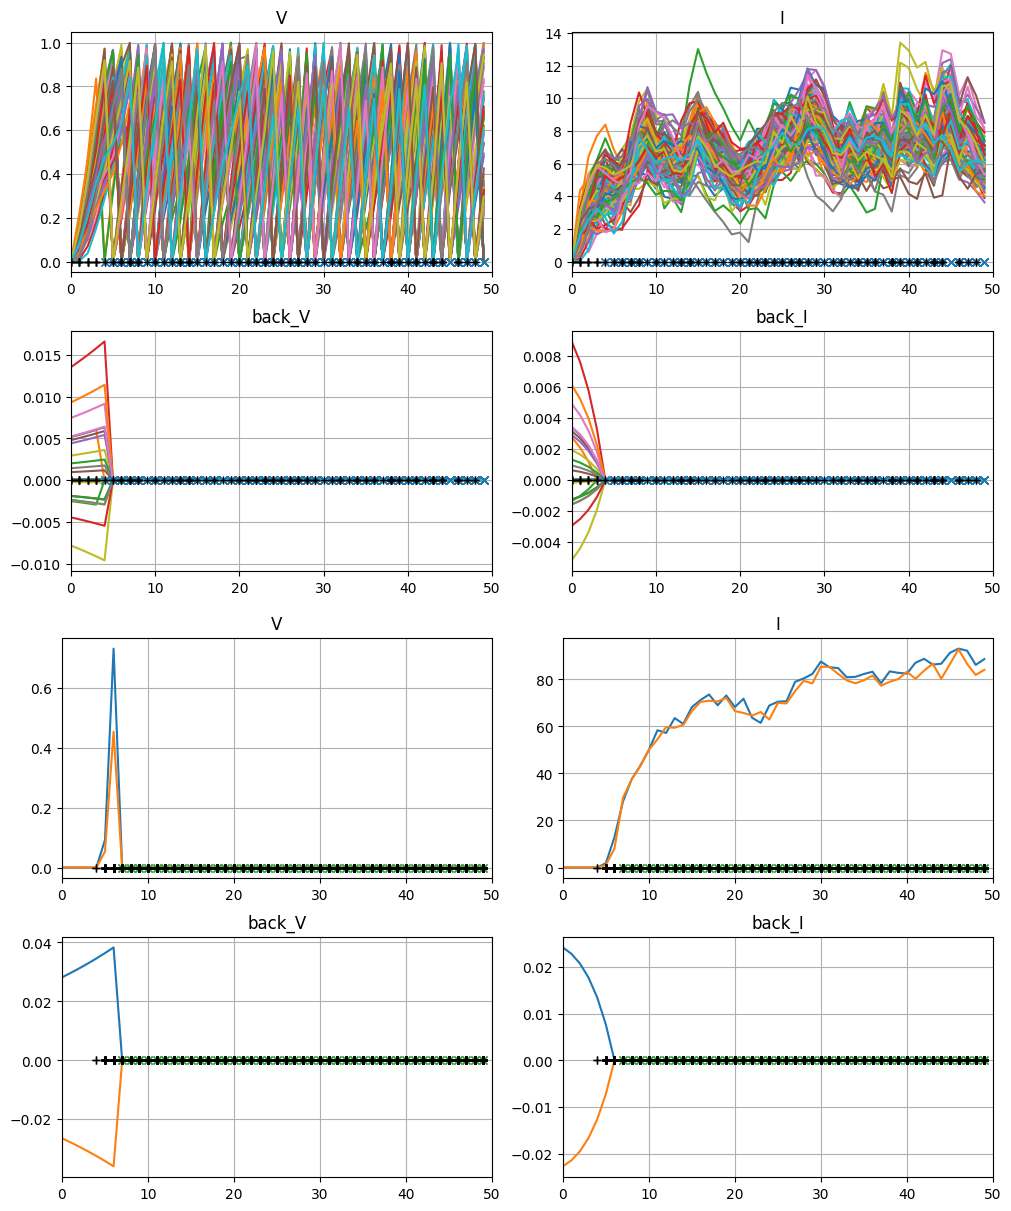

In [34]:
fig = plt.figure(figsize=(10, 12), constrained_layout=True)
subfigs = fig.subfigures(2, 1)

for subfig, V, I, lV, lI, out_spike_source, in_spike_source, dim_out, dim_in in zip(
    subfigs,
    Vs,
    Is,
    lVs,
    lIs,
    sources[1:],
    sources[:-1],
    dims[1:],
    dims[:-1],
):
    axs = subfig.subplots(2, 2)
    for ax, data, title in zip(
        axs.T.flatten(), [V, lV, I, lI], ["V", "back_V", "I", "back_I"]
    ):
        # for n in range(dim_out) :
        ax.plot(data[:, 0].cpu().data.numpy())

        # print(in_spike_source, out_spike_source)
        out_spike_times = all_spike_times[out_spike_source]["all"]
        in_spike_times = all_spike_times[in_spike_source]["all"]

        ax.plot(
            np.concatenate(list(out_spike_times.values())),
            np.zeros_like(np.concatenate(list(out_spike_times.values()))),
            "x",
        )
        ax.plot(
            np.concatenate(list(in_spike_times.values())),
            np.zeros_like(np.concatenate(list(in_spike_times.values()))),
            "+",
            color='black'
        )

        ax.set_title(title)
        ax.grid(visible=True)
        ax.set_xlim(0, timesteps)

In [37]:
[s.float().mean() for s in all_out_spikes]

[tensor(0.2560, device='cuda:0'), tensor(0.8600, device='cuda:0')]

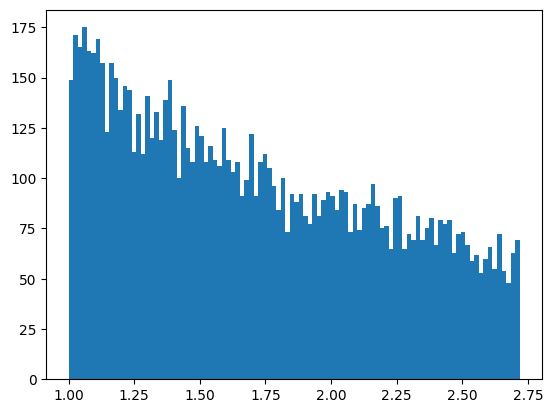

In [45]:
plt.hist([np.exp(np.random.rand()) for _ in range(10000)], bins=100);

In [50]:
np.random.uniform(np.log(0.1), np.log(1e-3))

-5.904524546446405

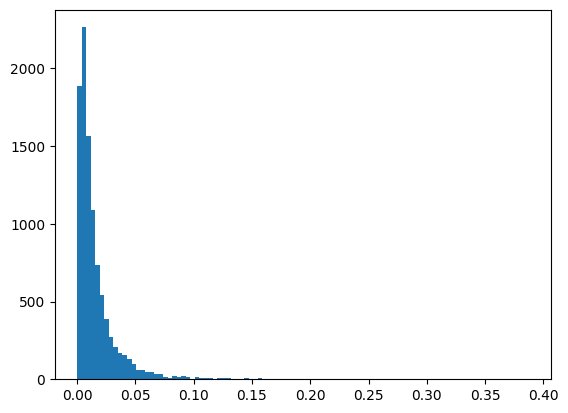

In [95]:
plt.hist(np.exp(np.random.normal(np.log(1e-2), 1, size=10000)), bins=100);
# plt.loglog()

In [90]:
np.log(1e-2)

-4.605170185988091

In [178]:
unique_times = np.unique(np.concatenate(list(all_spike_times[0]['all'].values())), return_counts=True)[1]
unique_times.sort()
unique_times

array([ 2, 14, 15, 17, 18, 18, 19, 19, 19, 21, 23, 23, 24, 24, 24, 24, 24,
       26, 26, 27, 27, 27, 28, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31,
       31, 31, 32, 32, 33, 33, 33, 33, 34, 34, 36, 36, 38, 39])

In [177]:
offline_times = all_spike_times[0]['all']